## Feature Extraction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import os
import json
import re
import string
from tqdm import tqdm
import sys
import subprocess
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import scipy.sparse as sp
from datasets import load_dataset
import unicodedata
import contractions
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from typing import List, Dict, Any

/opt/anaconda3/envs/NLP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('clean.csv')

In [4]:
df['clean_text']

0       proud friend overcoming struggle make wonder e...
1       finally finished project ! exhausting thrilled...
2       laughter shared reunion best part week miss mo...
3          everything feel uncertain right ? wish clarity
4       graduation feel exciting sad end something bea...
                              ...                        
1869    feel like lost sight truly matter need take st...
1870    excited see family long way long since got tog...
1871      shake nagging feeling not NOT_enough exhausting
1872    love rainy day give chance relax reflect every...
1873    feeling little stuck lately like rut hard brea...
Name: clean_text, Length: 1874, dtype: object

In [5]:
# Create directory to save features
output_dir = 'emotionverse_features_advanced'
os.makedirs(output_dir, exist_ok=True)

In [6]:
# Function to save labels and IDs for later use
def save_labels_and_ids(df, output_file='emotionverse_labels.csv'):
    labels_df = df[['sentiment', 'primary_emotion']].copy()
    labels_df['id'] = list(range(len(df)))  # Add ID column
    labels_df.to_csv(output_file, index=False)
    print(f"Labels saved to {output_file}")
    return labels_df

In [7]:
# 1. Bag of Words (BoW)
def extract_and_save_bow(df, max_features=5000, ngram_range=(1, 1), output_file='bow_features.npz'):
    print("Extracting Bag of Words features...")
    vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_bow = vectorizer.fit_transform(df['clean_text'])
    
    # Save sparse matrix
    sp.save_npz(output_file, X_bow)
    
    # Save feature names and vocabulary for reference
    feature_names = vectorizer.get_feature_names_out()
    vocab = vectorizer.vocabulary_
    with open(output_file.replace('.npz', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'vocab_size': len(feature_names),
            'shape': X_bow.shape,
            'ngram_range': ngram_range,
            'max_features': max_features
        }, f)

    print(f"BoW Dimensions: {X_bow.shape}")
    print(f"Feature space size: {len(feature_names)}")
    print(f"Saved to {output_file} and {output_file.replace('.npz', '_metadata.json')}")
    return X_bow, vectorizer

In [8]:
# 2. TF-IDF
def extract_and_save_tfidf(df, max_features=5000, ngram_range=(1, 1), output_file='tfidf_features.npz'):
    print("Extracting TF-IDF features...")
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_tfidf = vectorizer.fit_transform(df['clean_text'])
    
    # Save sparse matrix
    sp.save_npz(output_file, X_tfidf)
    
    # Save feature names and vocabulary for reference
    feature_names = vectorizer.get_feature_names_out()
    vocab = vectorizer.vocabulary_
    with open(output_file.replace('.npz', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'vocab_size': len(feature_names),
            'shape': X_tfidf.shape,
            'ngram_range': ngram_range,
            'max_features': max_features
        }, f)
    
    print(f"TF-IDF Dimensions: {X_tfidf.shape}")
    print(f"Feature space size: {len(feature_names)}")
    print(f"Saved to {output_file} and {output_file.replace('.npz', '_metadata.json')}")
    return X_tfidf, vectorizer

# Sentiment lexicons:

In [9]:
# 3. VADER lexicon
def extract_vader_lexicon_features(df, vectorizer, text_column='clean_text', output_file='vader_lexicon_features.npy'):
    """
    Extract VADER sentiment lexicon features aligned with vocabulary.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the text data
    vectorizer : sklearn vectorizer
        Fitted vectorizer (TfidfVectorizer or CountVectorizer)
    text_column : str
        Column name containing the processed text
    output_file : str
        Path to save the numpy array with features
        
    Returns:
    --------
    tuple
        (word_level_features, document_level_features)
    """
    print("Extracting VADER Sentiment Lexicon features...")
    
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()
    
    # Get vocabulary from the vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Create lexicon scores for each word in the vocabulary
    lexicon_scores = np.zeros((len(feature_names), 4))  # neg, neu, pos, compound
    
    for i, word in tqdm(enumerate(feature_names), total=len(feature_names), desc="Calculating VADER scores"):
        scores = sid.polarity_scores(word)
        lexicon_scores[i, 0] = scores['neg']
        lexicon_scores[i, 1] = scores['neu']
        lexicon_scores[i, 2] = scores['pos']
        lexicon_scores[i, 3] = scores['compound']
    
    # Save as numpy array
    #np.save(output_file, lexicon_scores)
    
    # Save metadata
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'score_types': ['negative', 'neutral', 'positive', 'compound'],
            'shape': lexicon_scores.shape,
            'lexicon': 'VADER'
        }, f)
    
    print(f"Word-level Lexicon Feature Dimensions: {lexicon_scores.shape}")
    print(f"Saved to {output_file} and {output_file.replace('.npy', '_metadata.json')}")
    
    # Create and save document-level features based on scores
    document_lexicon_features = np.zeros((len(df), 4))
    X = vectorizer.transform(df[text_column])
    
    # For each document, calculate the weighted average of sentiment scores
    for i in tqdm(range(len(df)), desc="Creating document features"):
        # Get indices of non-zero words and their TF-IDF/BoW values
        row = X[i].toarray().flatten()
        nonzero_indices = np.nonzero(row)[0]
        weights = row[nonzero_indices]
        
        # Skip if no terms are found
        if len(nonzero_indices) == 0:
            continue
            
        # Compute weighted average of scores for each sentiment dimension
        weighted_scores = np.zeros(4)
        for j, idx in enumerate(nonzero_indices):
            weighted_scores += weights[j] * lexicon_scores[idx]
            
        # Normalize by the sum of weights
        document_lexicon_features[i] = weighted_scores / weights.sum()
    
    # Save document-level features
    #doc_output_file = output_file.replace('.npy', '_document.npy')
    #np.save(doc_output_file, document_lexicon_features)
    
    
    print(f"Document-level Lexicon Feature Dimensions: {document_lexicon_features.shape}")

    
    return lexicon_scores, document_lexicon_features

In [10]:
# Combine Features

def combine_features(tfidf_features=None, vader_features=None, lexicon_features=None, embedding_features=None, output_file="emotionverse_features_advanced/Combinedfeatures.npy"):
    """
    Combine different feature sets for later use in classification.
    
    Parameters:
    -----------
    tfidf_features : scipy.sparse matrix
        TF-IDF features
    bow_features : scipy.sparse matrix
        Bag of Words features
    vader_features : numpy.ndarray, optional
        VADER sentiment features
    nrc_features : numpy.ndarray, optional
        NRC emotion features
    embedding_features : numpy.ndarray, optional
        Text embedding features
        
    Returns:
    --------
    dict
        Dictionary with feature matrices and metadata
    """
    from scipy.sparse import hstack, csr_matrix
    import scipy.sparse as sp

    features={}
    
    if tfidf_features is not None:
        features['tfidf'] = tfidf_features

    if vader_features is not None:
        features['vader'] = csr_matrix(vader_features)
        
    if lexicon_features is not None:
        features['nrc'] = csr_matrix(lexicon_features)
        
    if embedding_features is not None:
        features['embeddings'] = csr_matrix(embedding_features)
    
    # Create a combined sparse feature matrix
    feature_matrices = [features[key] for key in features]
    combined_features = hstack(feature_matrices)
    
    features['combined'] = combined_features
    
    # Create feature information
    feature_info = {
        'shapes': {k: v.shape for k, v in features.items()},
        'dtypes': {k: str(v.dtype) for k, v in features.items()},
        'sparsity': {k: 1.0 - (v.nnz / (v.shape[0] * v.shape[1])) 
                    if sp.issparse(v) else np.count_nonzero(v) / v.size
                    for k, v in features.items()}
    }
    
    features['info'] = feature_info
    np.save(output_file, features['combined'])
    # Save document-level metadata
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'shapes' : feature_info['shapes'],
            'dtypes' : feature_info['dtypes'],
            'sparsity' : feature_info['sparsity'],
        }, f)




    return features

In [11]:
def extract_and_save_sentiment_embeddings_pro(df, output_file='sentiment_embeddings_pro.npy', 
                                         model_name='all-MiniLM-L6-v2',
                                         text_column='clean_text',
                                         label_column='sentiment',
                                         batch_size=32):
    """
    Extract sentence embeddings optimized for sentiment analysis with 5 labels.
    
    Parameters:
    - df: DataFrame with preprocessed text and sentiment labels
    - output_file: Where to save the embeddings
    - model_name: SentenceTransformer model to use
    - text_column: Column name containing preprocessed text
    - label_column: Column name containing sentiment labels
    - batch_size: Batch size for embedding extraction
    
    Returns:
    - X_embeddings: The extracted embeddings
    - labels: The corresponding sentiment labels
    """
    print(f"Extracting sentiment-optimized embeddings using {model_name}...")
    
    # Verify sentiment labels
    sentiment_labels = df[label_column].unique()
    print(f"Found {len(sentiment_labels)} sentiment classes: {sentiment_labels}")
    
    from sklearn.preprocessing import LabelEncoder

    # Instead of the manual mapping
    label_encoder = LabelEncoder()
    df['label_numeric'] = label_encoder.fit_transform(df[label_column])
    labels = df['label_numeric'].values

    
    # Check for missing values
    if df[text_column].isna().any():
        print(f"Warning: Found {df[text_column].isna().sum()} missing values in '{text_column}'. Filling with empty string.")
        df[text_column] = df[text_column].fillna('')
    
    # Load Sentence-BERT model
    try:
        from sentence_transformers import SentenceTransformer
        import torch
        
        # Determine device
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using {device} for embedding extraction")
        
        model = SentenceTransformer(model_name)
        model.to(device)
        
        # Extract embeddings for preprocessed text
        X_embeddings = model.encode(
            df[text_column].tolist(),
            batch_size=batch_size,
            show_progress_bar=True,
            device=device,
            convert_to_numpy=True
        )
        
        # Save embeddings and labels
        np.save(output_file, X_embeddings)
        np.save(output_file.replace('.npy', '_labels.npy'), labels)
        
        # Save metadata
        with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
            import json
            json.dump({
                'model': model_name,
                'embedding_dim': X_embeddings.shape[1],
                'shape': X_embeddings.shape,
                'sentiment_classes': list(sentiment_labels),
            }, f)
        
        print(f"Embedding Dimensions: {X_embeddings.shape}")
        print(f"Saved embeddings to {output_file}")
        print(f"Saved labels to {output_file.replace('.npy', '_labels.npy')}")
        print(f"Saved metadata to {output_file.replace('.npy', '_metadata.json')}")
        
        return X_embeddings, labels
    
    except Exception as e:
        print(f"Error extracting embeddings: {e}")
        raise

In [12]:
# Custom Lexicon

SENTIMENT_LABELS = ['Mixed', 'Negative', 'Positive', 'Neutral', 'Ambiguous']

def create_sentiment_lexicon(texts: List[str], labels: List[str]) -> Dict[str, Any]:
    label_word_freq = {label: defaultdict(int) for label in SENTIMENT_LABELS}
    word_total_freq = defaultdict(int)

    for text, label in zip(texts, labels):
        words = text.lower().split()
        for word in words:
            label_word_freq[label][word] += 1
            word_total_freq[word] += 1

    lexicon = {}
    for word in word_total_freq:
        word_features = {
            'total_freq': word_total_freq[word],
            'label_ratios': {}
        }
        for label in SENTIMENT_LABELS:
            label_freq = label_word_freq[label][word]
            word_features['label_ratios'][label] = (
                label_freq / word_total_freq[word] if word_total_freq[word] > 0 else 0
            )
        lexicon[word] = word_features

    return lexicon

def generate_5d_lexicon_features(
    df: pd.DataFrame,
    text_col: str = 'clean_text',
    label_col: str = 'sentiment',
    output_file: str = 'custom_lexicon_features.npy'
) -> np.ndarray:
    """
    Generate and save 5D lexicon features (one per sentiment class).
    Returns a NumPy array of shape (n_docs, 5).
    """
    print("Creating 5D sentiment lexicon features...")
    lexicon = create_sentiment_lexicon(df[text_col].tolist(), df[label_col].tolist())

    doc_features = np.zeros((len(df), len(SENTIMENT_LABELS)))

    for i, text in tqdm(enumerate(df[text_col]), total=len(df)):
        words = text.lower().split()
        sentiment_sums = np.zeros(len(SENTIMENT_LABELS))
        word_count = 0

        for word in words:
            if word in lexicon:
                for j, label in enumerate(SENTIMENT_LABELS):
                    sentiment_sums[j] += lexicon[word]['label_ratios'][label]
                word_count += 1

        if word_count > 0:
            doc_features[i] = sentiment_sums / word_count
        else:
            doc_features[i] = 0

    print("Lexicon feature shape:", doc_features.shape)

    # Save features
    np.save(output_file, doc_features)

    # Save metadata
    metadata = {
        'features': SENTIMENT_LABELS,
        'shape': doc_features.shape,
        'source': 'custom lexicon based on training data',
        'text_column': text_col,
        'label_column': label_col
    }
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Saved features to {output_file}")
    print(f"Saved metadata to {output_file.replace('.npy', '_metadata.json')}")

    return doc_features

In [13]:

# Main function to extract all features
def extract_all_advanced_features(df, output_dir='emotionverse_features_advanced'):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define file paths
    bow_file = os.path.join(output_dir, 'bow_features.npz')
    tfidf_file = os.path.join(output_dir, 'tfidf_features.npz')
    sentence_emb_file = os.path.join(output_dir, 'sentence_embeddings.npy')
    labels_file = os.path.join(output_dir, 'emotionverse_labels.csv')
    tf_lexi =  os.path.join(output_dir, 'tf_lexi.npy')
    tf_vader_file = os.path.join(output_dir, 'tf_vader_file.npy')
    bert_vader_file = os.path.join(output_dir, 'bert_vader_file.npy')
    bert_lexi = os.path.join(output_dir, 'bert_lexi.npy')
    tf_bert_vader_file = os.path.join(output_dir, 'tf_bert_vader_file.npy')
    tf_bert_lexi = os.path.join(output_dir, 'tf_bert_lexi.npy')
    my_lexicon = os.path.join(output_dir, 'custom_lexicon_features.npy')


    # Extract and save features
    print("\n--- Starting advanced feature extraction ---\n")
    
    # 1. Extract BoW
    X_bow, bow_vectorizer = extract_and_save_bow(df, output_file=bow_file)
    
    # 2. Extract TF-IDF
    X_tfidf, tfidf_vectorizer = extract_and_save_tfidf(df, output_file=tfidf_file)

    
    # 3. Extract sentence embeddings with Sentence-BERT

    sentence_pro, _= extract_and_save_sentiment_embeddings_pro(df, output_file= sentence_emb_file)
    
    # 4. Save labels
    labels_df = save_labels_and_ids(df, output_file=labels_file)
    

    _, vader_features = extract_vader_lexicon_features(df, tfidf_vectorizer)

        
    lexicon_feats = generate_5d_lexicon_features(
        df,
        text_col='clean_text',
        label_col='sentiment',
        output_file= my_lexicon
    )
    


    bertsentencescaler = MinMaxScaler()
    scaled_bert_sentence = bertsentencescaler.fit_transform(sentence_pro)

    scaler_vader = MinMaxScaler()
    scaled_vader_features = scaler_vader.fit_transform(vader_features)

    scaler_my = MinMaxScaler()
    scaled_my_features = scaler_my.fit_transform(lexicon_feats)

    scaler_tf = MaxAbsScaler()
    scaled_tf = scaler_tf.fit_transform(X_tfidf)

    
    tf_lexicon = combine_features(
        scaled_tf, 
        None,
        scaled_my_features,
        None,
        output_file=tf_lexi
    )

    tf_vader= combine_features(
        scaled_tf, 
        scaled_vader_features,
        None,
        None,
        output_file=tf_vader_file
    )
    bert_vader = combine_features(
        None,
        scaled_vader_features,
        None,
        scaled_bert_sentence,
        output_file= bert_vader_file
    )

    bert_lexicon = combine_features(
        None,
        None,
        scaled_my_features,
        scaled_bert_sentence,
        output_file= bert_lexi
    )

    tf_bert_vader = combine_features(
        scaled_tf,
        scaled_vader_features,
        None,
        scaled_bert_sentence,
        output_file= tf_bert_vader_file
    )
        
    tf_bert_lexicon = combine_features(
        scaled_tf,
        None,
        scaled_my_features,
        scaled_bert_sentence,
        output_file= tf_bert_lexi
    )

    print("\n--- Feature extraction completed! ---")
    print(f"All features saved in {output_dir}/")
    
    return {
        'bow': (X_bow, bow_vectorizer),
        'tfidf': (X_tfidf, tfidf_vectorizer),
        'vader' : vader_features,
        'my_features'  : lexicon_feats,
        'bert' : sentence_pro,
        'tf_lexicon' : tf_lexicon,
        'tf_vader' : tf_vader,
        'bert_vader' : bert_vader,
        'bert_lexicon' : bert_lexicon,
        'tf_bert_vader' : tf_bert_vader,
        'tf_bert_lexicon' : tf_bert_lexicon
    }

In [14]:
features = extract_all_advanced_features(df)


--- Starting advanced feature extraction ---

Extracting Bag of Words features...
BoW Dimensions: (1874, 3269)
Feature space size: 3269
Saved to emotionverse_features_advanced/bow_features.npz and emotionverse_features_advanced/bow_features_metadata.json
Extracting TF-IDF features...
TF-IDF Dimensions: (1874, 3269)
Feature space size: 3269
Saved to emotionverse_features_advanced/tfidf_features.npz and emotionverse_features_advanced/tfidf_features_metadata.json
Extracting sentiment-optimized embeddings using all-MiniLM-L6-v2...
Found 5 sentiment classes: ['Mixed' 'Positive' 'Ambiguous' 'Negative' 'Neutral']
Using cpu for embedding extraction


Batches: 100%|██████████| 59/59 [00:01<00:00, 35.93it/s]


Embedding Dimensions: (1874, 384)
Saved embeddings to emotionverse_features_advanced/sentence_embeddings.npy
Saved labels to emotionverse_features_advanced/sentence_embeddings_labels.npy
Saved metadata to emotionverse_features_advanced/sentence_embeddings_metadata.json
Labels saved to emotionverse_features_advanced/emotionverse_labels.csv
Extracting VADER Sentiment Lexicon features...


Calculating VADER scores: 100%|██████████| 3269/3269 [00:00<00:00, 125681.10it/s]


Word-level Lexicon Feature Dimensions: (3269, 4)
Saved to vader_lexicon_features.npy and vader_lexicon_features_metadata.json


Creating document features: 100%|██████████| 1874/1874 [00:00<00:00, 21118.81it/s]


Document-level Lexicon Feature Dimensions: (1874, 4)
Creating 5D sentiment lexicon features...


100%|██████████| 1874/1874 [00:00<00:00, 59565.81it/s]


Lexicon feature shape: (1874, 5)
Saved features to emotionverse_features_advanced/custom_lexicon_features.npy
Saved metadata to emotionverse_features_advanced/custom_lexicon_features_metadata.json

--- Feature extraction completed! ---
All features saved in emotionverse_features_advanced/


## Extracted Features EDA

In [27]:
# Exploratory analysis of the extracted features
print("\n--- Analysis of Extracted Features ---\n")


--- Analysis of Extracted Features ---



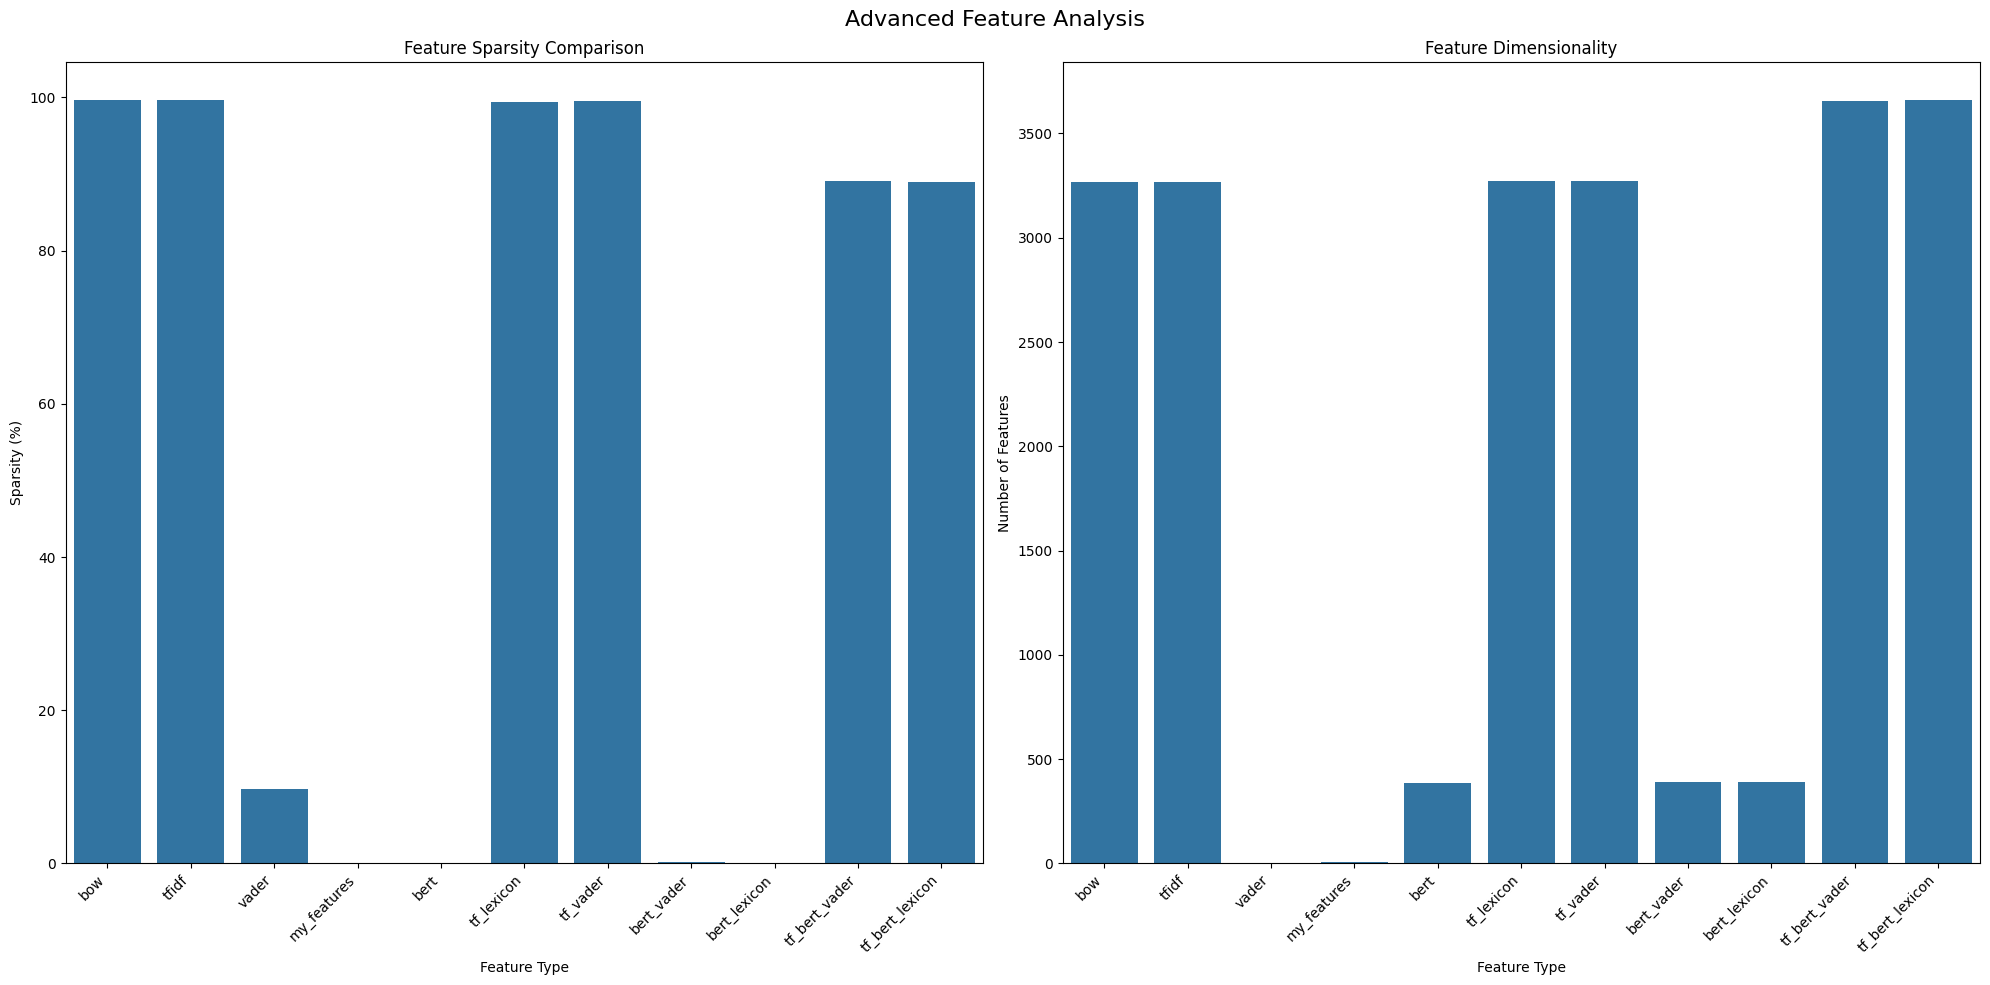


--- Detailed Feature Summary ---

BOW Features:
Shape: (1874, 3269)
Sparsity: 0.40%

TFIDF Features:
Shape: (1874, 3269)
Sparsity: 0.40%

VADER Features:
Shape: (1874, 4)
Mean: 0.257772818924083
Std Dev: 0.2989395646743185

MY_FEATURES Features:
Shape: (1874, 5)
Mean: 0.19999999999999998
Std Dev: 0.1757115392229765

BERT Features:
Shape: (1874, 384)
Mean: -0.00013041149941273034
Std Dev: 0.05103086680173874

TF_LEXICON Features:
Shape: (1874, 3274)
Sparsity: 0.56%

TF_VADER Features:
Shape: (1874, 3273)
Sparsity: 0.51%

BERT_VADER Features:
Shape: (1874, 388)
Sparsity: 99.85%

BERT_LEXICON Features:
Shape: (1874, 389)
Sparsity: 99.95%

TF_BERT_VADER Features:
Shape: (1874, 3657)
Sparsity: 10.95%

TF_BERT_LEXICON Features:
Shape: (1874, 3658)
Sparsity: 10.99%


In [17]:
def visualize_advanced_features(features):
    """
    Create comprehensive visualizations of feature characteristics.
    
    Parameters:
    features (dict): Dictionary containing feature representations
    """
    plt.figure(figsize=(20, 10))
    plt.suptitle('Advanced Feature Analysis', fontsize=16)
    
    def calculate_sparsity(feature):
        """Calculate sparsity for different feature types"""
        try:
            if isinstance(feature, tuple):
                feature = feature[0]  # For bow, tfidf which return (matrix, vectorizer)
            
            if sp.issparse(feature):
                # Sparse matrix sparsity
                total_elements = feature.shape[0] * feature.shape[1]
                zero_elements = total_elements - feature.nnz
                sparsity = (zero_elements / total_elements) * 100
            elif isinstance(feature, np.ndarray):
                # Numpy array sparsity
                total_elements = feature.size
                zero_elements = np.count_nonzero(feature == 0)
                sparsity = (zero_elements / total_elements) * 100
            elif isinstance(feature, dict) and 'combined' in feature:
                feature = feature['combined']
                total_elements = feature.shape[0] * feature.shape[1]
                zero_elements = total_elements - feature.nnz
                sparsity = (zero_elements / total_elements) * 100
            else:
                return 0
            return sparsity
        except Exception as e:
            print(f"Sparsity calculation error for feature: {e}")
            return 0
    
    # 1. Sparsity Comparison
    plt.subplot(1, 2, 1)
    sparsity_values = []
    feature_names = []
    
    for name, feature in features.items():
        try:
            sparsity = calculate_sparsity(feature)
            sparsity_values.append(sparsity)
            feature_names.append(name)
        except Exception as e:
            print(f"Error processing {name}: {e}")
    
    sns.barplot(x=feature_names, y=sparsity_values)
    plt.title('Feature Sparsity Comparison')
    plt.xlabel('Feature Type')
    plt.ylabel('Sparsity (%)')
    plt.xticks(rotation=45, ha='right')
    
    # 2. Feature Shapes
    plt.subplot(1, 2, 2)
    shapes = []
    
    for name, feature in features.items():
        try:
            if isinstance(feature, tuple):
                shapes.append(feature[0].shape[1])
            elif isinstance(feature, np.ndarray):
                shapes.append(feature.shape[1])
            elif isinstance(feature, dict) and 'combined' in feature:
                shapes.append(feature['combined'].shape[1])
            else:
                shapes.append(0)
        except Exception as e:
            print(f"Shape calculation error for {name}: {e}")
            shapes.append(0)
    
    sns.barplot(x=feature_names, y=shapes)
    plt.title('Feature Dimensionality')
    plt.xlabel('Feature Type')
    plt.ylabel('Number of Features')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Detailed Feature Summary
def print_feature_summary(features):
    print("\n--- Detailed Feature Summary ---")
    for name, feature in features.items():
        try:
            if isinstance(feature, tuple):
                feature_matrix = feature[0]
            elif isinstance(feature, dict) and 'combined' in feature:
                feature_matrix = feature['combined']
            elif isinstance(feature, np.ndarray):
                feature_matrix = feature
            else:
                continue
            
            print(f"\n{name.upper()} Features:")
            print(f"Shape: {feature_matrix.shape}")
            
            if sp.issparse(feature_matrix):
                print(f"Sparsity: {(feature_matrix.nnz / (feature_matrix.shape[0] * feature_matrix.shape[1]) * 100):.2f}%")
            else:
                print(f"Mean: {feature_matrix.mean()}")
                print(f"Std Dev: {feature_matrix.std()}")
        except Exception as e:
            print(f"Could not analyze {name}: {e}")

# Visualize and summarize features
visualize_advanced_features(features)
print_feature_summary(features)

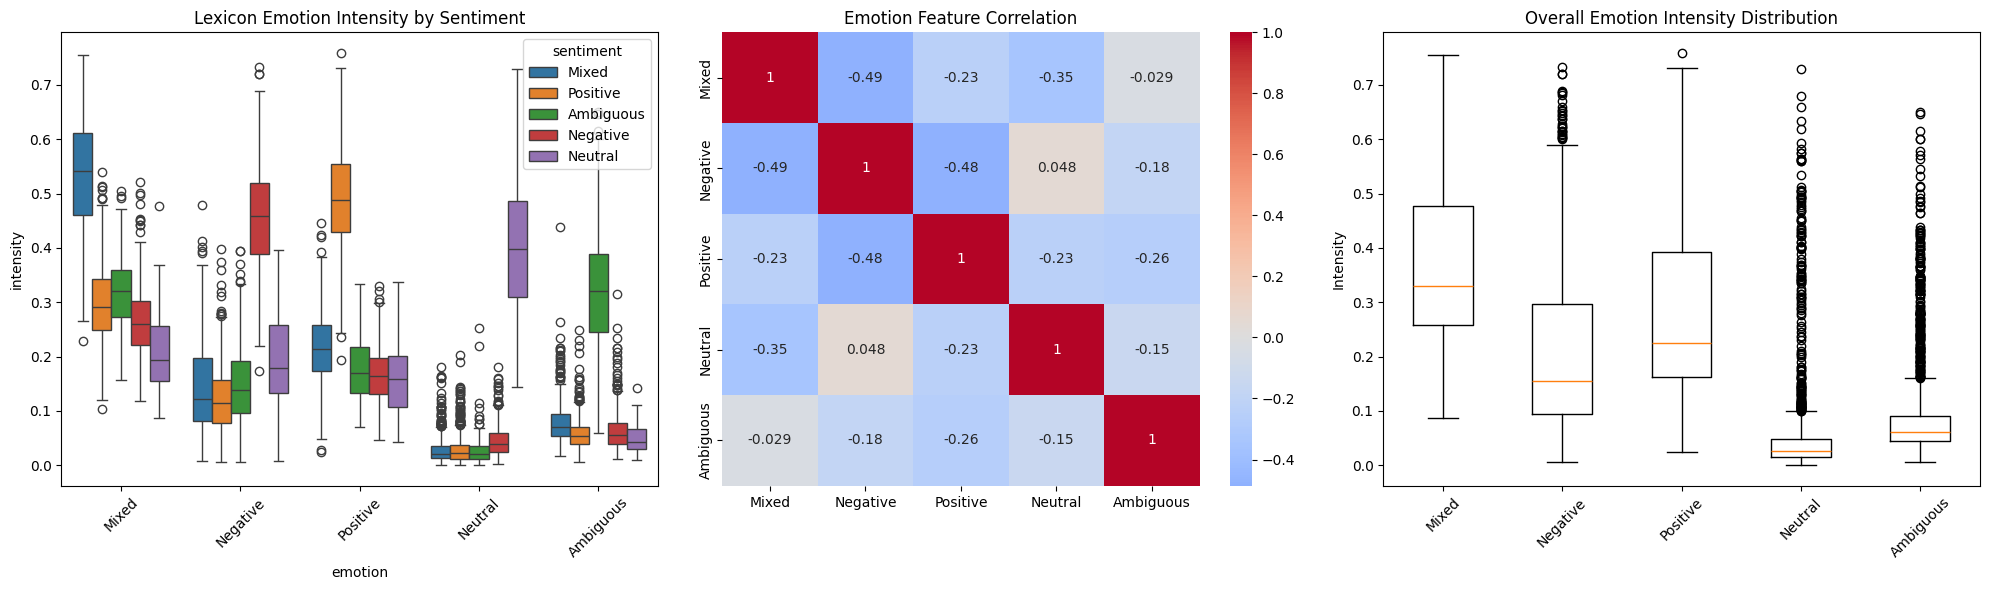


--- Emotion Lexicon Statistical Summary ---

Mixed Emotion Statistics:
Mean: 0.3703
Std Dev: 0.1460

Negative Emotion Statistics:
Mean: 0.2105
Std Dev: 0.1560

Positive Emotion Statistics:
Mean: 0.2779
Std Dev: 0.1532

Neutral Emotion Statistics:
Mean: 0.0530
Std Dev: 0.0919

Ambiguous Emotion Statistics:
Mean: 0.0883
Std Dev: 0.0866


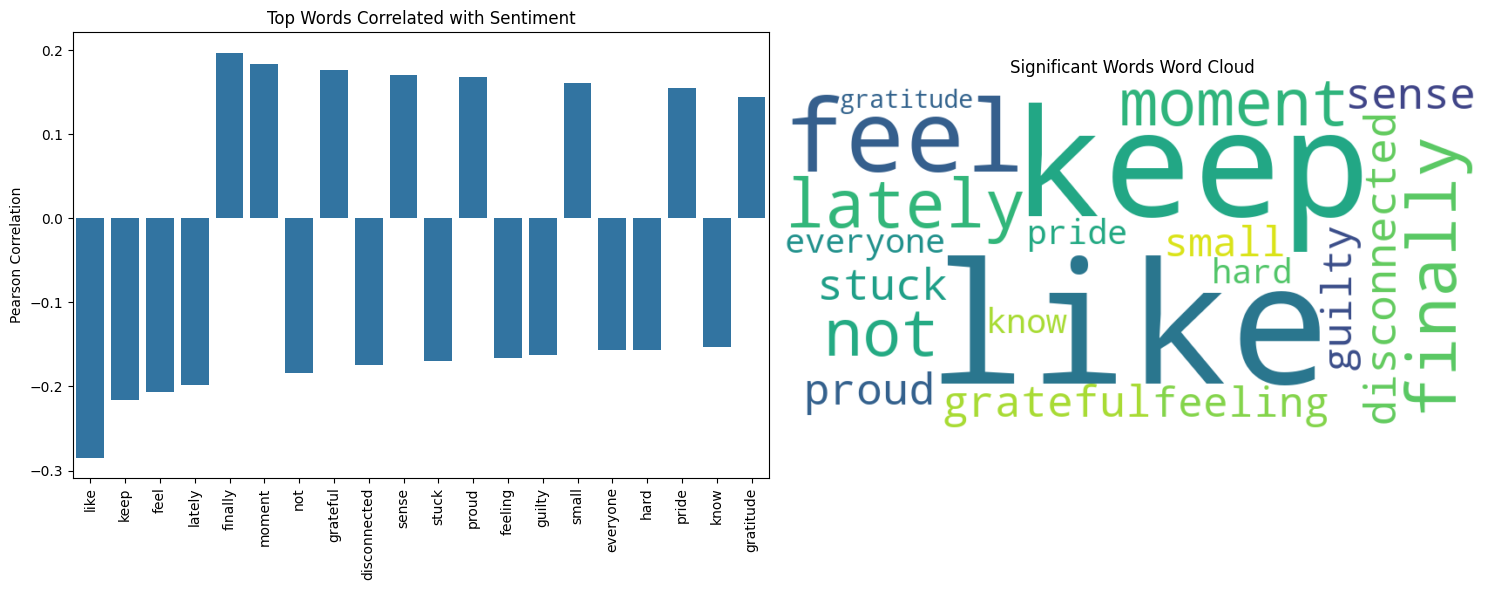


--- Significant Word-Sentiment Correlations ---
Word | Correlation | P-Value
----------------------------------------
like       | -0.2845 | 0.0000
keep       | -0.2165 | 0.0000
feel       | -0.2069 | 0.0000
lately     | -0.1980 | 0.0000
finally    | +0.1972 | 0.0000
moment     | +0.1835 | 0.0000
not        | -0.1835 | 0.0000
grateful   | +0.1759 | 0.0000
disconnected | -0.1739 | 0.0000
sense      | +0.1705 | 0.0000
stuck      | -0.1701 | 0.0000
proud      | +0.1682 | 0.0000
feeling    | -0.1664 | 0.0000
guilty     | -0.1623 | 0.0000
small      | +0.1612 | 0.0000
everyone   | -0.1566 | 0.0000
hard       | -0.1566 | 0.0000
pride      | +0.1556 | 0.0000
know       | -0.1527 | 0.0000
gratitude  | +0.1442 | 0.0000


In [42]:
def lexicon_emotion_dynamics(features, df):
    """
    Analyze emotion lexicon features and their distribution.
    
    Parameters:
    - features: Dictionary of extracted features
    - df: Original DataFrame with labels
    """
    # Use custom lexicon features
    lexicon_features = features['my_features']
    
    plt.figure(figsize=(20, 6))
    
    # 1. Emotion Intensity Distribution by Sentiment
    plt.subplot(1, 3, 1)
    emotion_labels = ['Mixed', 'Negative', 'Positive', 'Neutral', 'Ambiguous']
    
    # Box plot of lexicon features across different sentiments
    lexicon_df = pd.DataFrame(lexicon_features, columns=emotion_labels)
    lexicon_df['sentiment'] = df['sentiment']
    
    melted_df = lexicon_df.melt(id_vars=['sentiment'], 
                                 var_name='emotion', 
                                 value_name='intensity')
    
    sns.boxplot(x='emotion', y='intensity', hue='sentiment', data=melted_df)
    plt.title('Lexicon Emotion Intensity by Sentiment')
    plt.xticks(rotation=45)
    
    # 2. Emotion Correlation Heatmap
    plt.subplot(1, 3, 2)
    emotion_correlation = np.corrcoef(lexicon_features.T)
    
    sns.heatmap(emotion_correlation, 
                xticklabels=emotion_labels, 
                yticklabels=emotion_labels,
                cmap='coolwarm', center=0, annot=True)
    plt.title('Emotion Feature Correlation')
    
    # 3. Emotion Intensity Distribution
    plt.subplot(1, 3, 3)
    plt.title('Overall Emotion Intensity Distribution')
    plt.boxplot(lexicon_features)
    plt.xticks(range(1, len(emotion_labels) + 1), emotion_labels, rotation=45)
    plt.ylabel('Intensity')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical Analysis
    print("\n--- Emotion Lexicon Statistical Summary ---")
    for label in emotion_labels:
        print(f"\n{label} Emotion Statistics:")
        print(f"Mean: {lexicon_features[:, emotion_labels.index(label)].mean():.4f}")
        print(f"Std Dev: {lexicon_features[:, emotion_labels.index(label)].std():.4f}")

def feature_interpretability_analysis(features, df, tfidf_vectorizer):
    """
    Analyze the most influential words for different sentiments.
    
    Parameters:
    - features: Dictionary of extracted features
    - df: Original DataFrame with labels
    - tfidf_vectorizer: TF-IDF vectorizer
    """
    # Create a fixed, ordered mapping for sentiment labels
    sentiment_order = {
        'Negative': 0,  # Most negative
        'Ambiguous': 1, 
        'Neutral': 2,   # Middle point
        'Mixed': 3,
        'Positive': 4   # Most positive
    }
    
    # Apply this consistent mapping
    sentiment_numeric = df['sentiment'].map(sentiment_order)
    
    # Get TF-IDF features and feature names
    tfidf_features = features['tfidf'][0]
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Calculate word-sentiment correlations
    word_sentiment_correlations = []
    
    for i in range(tfidf_features.shape[1]):
        feature_column = tfidf_features[:, i].toarray().flatten()
        corr, p_value = pearsonr(feature_column, sentiment_numeric)
        word_sentiment_correlations.append((feature_names[i], corr, p_value))
    
    # Sort and filter significant correlations
    significant_correlations = [
        (word, corr, p) for word, corr, p in word_sentiment_correlations 
        if abs(corr) > 0.1 and p < 0.05
    ]
    
    # Sort by absolute correlation
    top_words = sorted(significant_correlations, key=lambda x: abs(x[1]), reverse=True)[:20]
    
    plt.figure(figsize=(15, 6))
    
    # Bar plot of word-sentiment correlations
    plt.subplot(1, 2, 1)
    words = [word for word, _, _ in top_words]
    correlations = [corr for _, corr, _ in top_words]
    
    sns.barplot(x=words, y=correlations)
    plt.title('Top Words Correlated with Sentiment')
    plt.xticks(rotation=90)
    plt.ylabel('Pearson Correlation')
    
    # Word cloud of significant words
    plt.subplot(1, 2, 2)
    # Create a word cloud with word sizes based on absolute correlation
    word_freq = {word: abs(corr) for word, corr, _ in top_words}
    
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white').generate_from_frequencies(word_freq)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Significant Words Word Cloud')
    
    plt.tight_layout()
    plt.show()
    
    # Detailed word correlation report
    print("\n--- Significant Word-Sentiment Correlations ---")
    print("Word | Correlation | P-Value")
    print("-" * 40)
    for word, corr, p in top_words:
        print(f"{word:10} | {corr:+.4f} | {p:.4f}")

lexicon_emotion_dynamics(features, df)
feature_interpretability_analysis(features, df, features['tfidf'][1])


--- VADER vs Custom Lexicon Comparison ---
Correlation between VADER Compound and Custom Positive: 0.4777


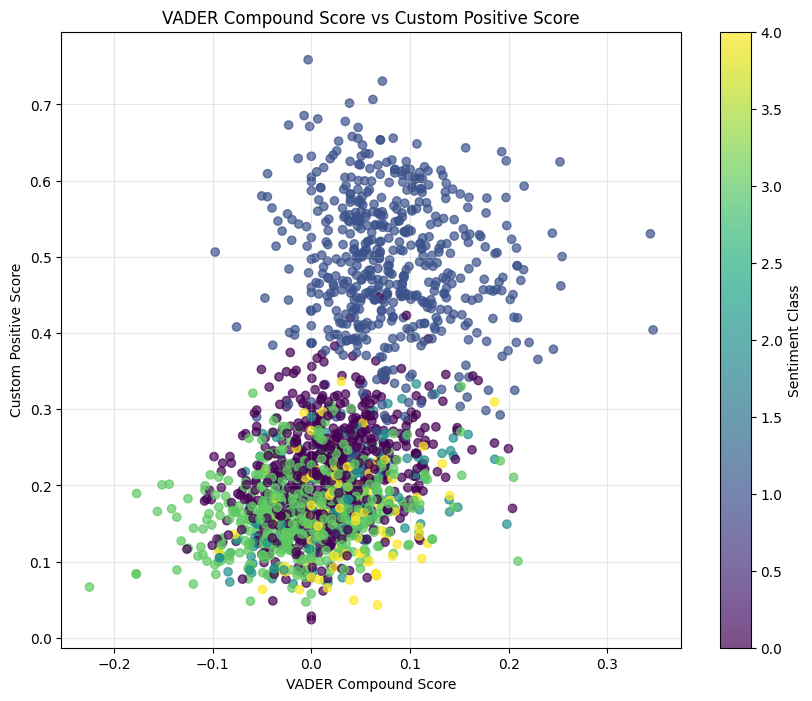

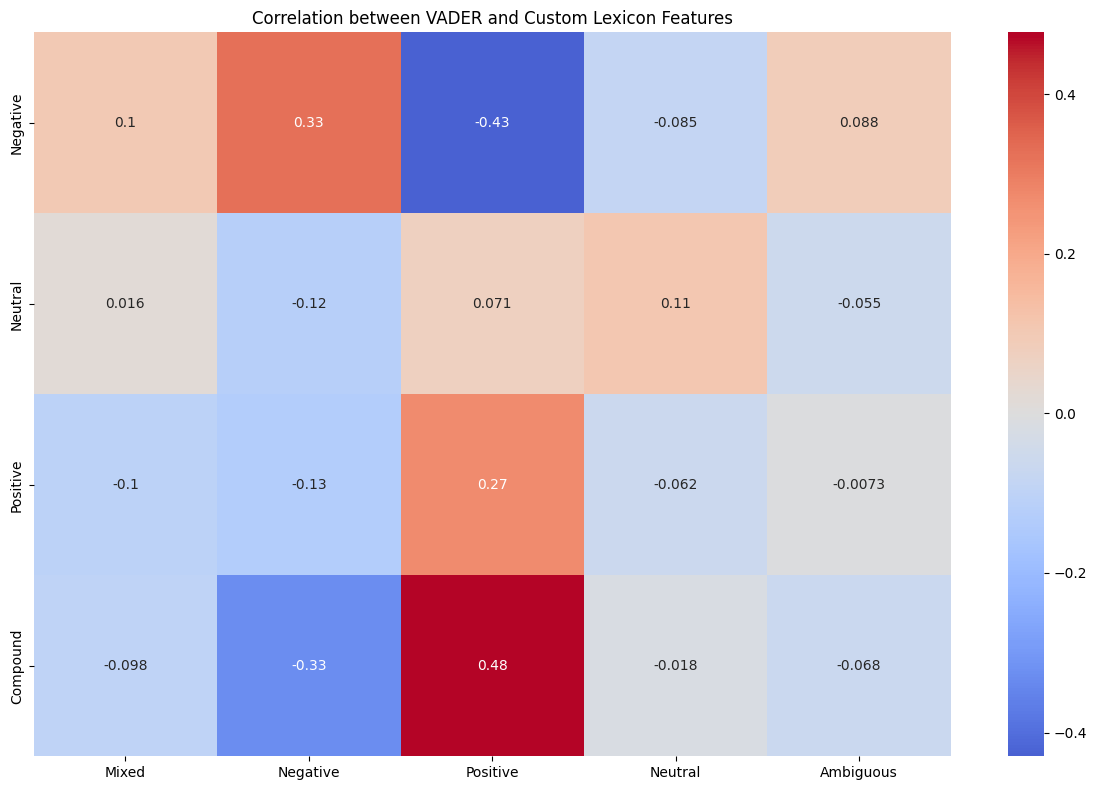

In [20]:
def vader_custom_lexicon_comparison(features, df):
    """
    Compare VADER lexicon and custom lexicon features
    
    Parameters:
    features (dict): Dictionary containing feature representations
    df (pd.DataFrame): Original dataframe with sentiment labels
    """
    if 'vader' in features and 'my_features' in features:
        vader_features = features['vader']
        custom_features = features['my_features']
        
        print("\n--- VADER vs Custom Lexicon Comparison ---")
        
        # Get sentiment for coloring
        sentiment_numeric = pd.factorize(df['sentiment'])[0]
        
        # Extract the compound score from VADER and positive score from custom lexicon
        vader_compound = vader_features[:, 3]  
        custom_positive = custom_features[:, 2]  
        
        # Calculate correlation
        corr, _ = pearsonr(vader_compound, custom_positive)
        print(f"Correlation between VADER Compound and Custom Positive: {corr:.4f}")
        
        # Visualize relationship
        plt.figure(figsize=(10, 8))
        
        plt.scatter(vader_compound, custom_positive, 
                   c=sentiment_numeric, 
                   cmap='viridis', 
                   alpha=0.7)
        
        plt.colorbar(label='Sentiment Class')
        plt.title('VADER Compound Score vs Custom Positive Score')
        plt.xlabel('VADER Compound Score')
        plt.ylabel('Custom Positive Score')
        plt.grid(alpha=0.3)
        plt.savefig('vader_custom_comparison.png', dpi=300)
        plt.show()
        
        # Create correlation matrix between all VADER and custom features
        vader_cols = ['Negative', 'Neutral', 'Positive', 'Compound']
        custom_cols = ['Mixed', 'Negative', 'Positive', 'Neutral', 'Ambiguous']
        
        corr_matrix = np.zeros((len(vader_cols), len(custom_cols)))
        
        for i, vader_col in enumerate(vader_cols):
            for j, custom_col in enumerate(custom_cols):
                corr, _ = pearsonr(vader_features[:, i], custom_features[:, j])
                corr_matrix[i, j] = corr
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, 
                   xticklabels=custom_cols, 
                   yticklabels=vader_cols, 
                   annot=True, 
                   cmap='coolwarm', 
                   center=0)
        plt.title('Correlation between VADER and Custom Lexicon Features')
        plt.tight_layout()
        plt.savefig('vader_custom_correlation_matrix.png', dpi=300)
        plt.show()
vader_custom_lexicon_comparison(features, df)

In [26]:
def analyze_sentence_with_lexicon(sentence, lexicon_features, df):
    """
    Analyze a single sentence using the custom lexicon, showing word contributions.
    
    Parameters:
    -----------
    sentence : str
        The sentence to analyze (should be from clean_text column)
    lexicon_features : numpy.ndarray
        The custom lexicon features array
    df : pandas.DataFrame
        The original dataframe with clean_text column
    
    Returns:
    --------
    dict
        Dictionary with lexicon scores and word contributions
    """
    # Find the sentence in the dataframe
    sentence_idx = df[df['clean_text'] == sentence].index
    
    if len(sentence_idx) == 0:
        print("Sentence not found in the dataframe")
        return None
    
    # Get the index of the sentence
    idx = sentence_idx[0]
    
    # Get the lexicon scores for this sentence
    lexicon_scores = lexicon_features[idx]
    
    # Define dimension names
    dimensions = ['Mixed', 'Negative', 'Positive', 'Neutral', 'Ambiguous']
    
    # Create a dictionary of words in the sentence
    words = sentence.split()
    
    # Create a simple lexicon from the dataset
    word_scores = {}
    for word in words:
        # Find all instances of this word in the dataset
        word_indices = df[df['clean_text'].str.contains(r'\b' + word + r'\b')].index
        
        if len(word_indices) > 0:
            # Calculate average lexicon scores for this word
            word_dim_scores = lexicon_features[word_indices].mean(axis=0)
            word_scores[word] = {dimensions[i]: float(word_dim_scores[i]) for i in range(len(dimensions))}
    
    # Calculate contributions for each dimension
    contributions = {dim: [] for dim in dimensions}
    
    for word, scores in word_scores.items():
        for dim in dimensions:
            contributions[dim].append((word, scores[dim]))
    
    # Sort contributions by importance
    for dim in dimensions:
        contributions[dim] = sorted(contributions[dim], key=lambda x: abs(x[1]), reverse=True)
    
    # Prepare results
    results = {
        'sentence': sentence,
        'lexicon_scores': {dimensions[i]: float(lexicon_scores[i]) for i in range(len(dimensions))},
        'word_contributions': contributions,
        'dominant_dimension': dimensions[np.argmax(lexicon_scores)],
        'dominant_score': float(np.max(lexicon_scores))
    }
    
    return results

In [46]:
# Get a sample sentence from your dataframe
sample_sentence = df['clean_text'].iloc[1422]  # For example

# Analyze the sentence
result = analyze_sentence_with_lexicon(sample_sentence, features['my_features'], df)

# Print results
print(f"Sentence: {result['sentence']}")
print(f"True Label: {df['sentiment'].iloc[1422]}")
print(f"Dominant dimension: {result['dominant_dimension']} ({result['dominant_score']:.4f})")
print("\nLexicon scores:")
for dim, score in result['lexicon_scores'].items():
    print(f"  {dim}: {score:.4f}")

print("\nTop contributing words per dimension:")
for dim in result['lexicon_scores'].keys():
    print(f"\n{dim}:")
    for word, score in result['word_contributions'][dim][:3]:  # Top 3 contributors
        print(f"  {word}: {score:.4f}")

Sentence: not NOT_sure NOT_stand NOT_anymore feel like middle something know something
True Label: Ambiguous
Dominant dimension: Negative (0.3339)

Lexicon scores:
  Mixed: 0.2427
  Negative: 0.3339
  Positive: 0.1637
  Neutral: 0.1143
  Ambiguous: 0.1455

Top contributing words per dimension:

Mixed:
  NOT_sure: 0.3498
  something: 0.3443
  know: 0.3256

Negative:
  NOT_stand: 0.3942
  like: 0.3486
  know: 0.3404

Positive:
  something: 0.2945
  feel: 0.2668
  like: 0.2315

Neutral:
  middle: 0.2301
  NOT_anymore: 0.1516
  not: 0.1207

Ambiguous:
  NOT_stand: 0.1500
  NOT_anymore: 0.1149
  NOT_sure: 0.1145


In [28]:
def analyze_sentence_with_vader(sentence, vader_features, df):
    """
    Analyze a single sentence using the VADER lexicon, showing word contributions.
    
    Parameters:
    -----------
    sentence : str
        The sentence to analyze (should be from clean_text column)
    vader_features : numpy.ndarray
        The VADER lexicon features array
    df : pandas.DataFrame
        The original dataframe with clean_text column
    
    Returns:
    --------
    dict
        Dictionary with VADER scores and word contributions
    """
    
    # Find the sentence in the dataframe
    sentence_idx = df[df['clean_text'] == sentence].index
    
    if len(sentence_idx) == 0:
        print("Sentence not found in the dataframe")
        return None
    
    # Get the index of the sentence
    idx = sentence_idx[0]
    
    # Get the VADER scores for this sentence
    vader_scores = vader_features[idx]
    
    # Define dimension names
    dimensions = ['Negative', 'Neutral', 'Positive', 'Compound']
    
    # Create a dictionary of words in the sentence
    words = sentence.split()
    
    # Initialize VADER analyzer for individual words
    sid = SentimentIntensityAnalyzer()
    
    # Get scores for each word
    word_scores = {}
    for word in words:
        # Get VADER scores for this word
        scores = sid.polarity_scores(word)
        word_scores[word] = {
            'Negative': scores['neg'],
            'Neutral': scores['neu'],
            'Positive': scores['pos'],
            'Compound': scores['compound']
        }
    
    # Calculate contributions for each dimension
    contributions = {dim: [] for dim in dimensions}
    
    for word, scores in word_scores.items():
        for dim in dimensions:
            contributions[dim].append((word, scores[dim]))
    
    # Sort contributions by importance
    for dim in dimensions:
        contributions[dim] = sorted(contributions[dim], key=lambda x: abs(x[1]), reverse=True)
    
    # Prepare results
    results = {
        'sentence': sentence,
        'vader_scores': {dimensions[i]: float(vader_scores[i]) for i in range(len(dimensions))},
        'word_contributions': contributions,
        'dominant_dimension': dimensions[np.argmax(vader_scores[:3])],  # Exclude compound from dominant
        'dominant_score': float(np.max(vader_scores[:3])),
        'compound_score': float(vader_scores[3])
    }
    
    return results

In [47]:
# Get a sample sentence from your dataframe
sample_sentence = df['clean_text'].iloc[1422]  # For example

# Analyze the sentence
result = analyze_sentence_with_vader(sample_sentence, features['vader'], df)

# Print results
print(f"Sentence: {result['sentence']}")
print(f"True Label: {df['sentiment'].iloc[1422]}")
print(f"Dominant dimension: {result['dominant_dimension']} ({result['dominant_score']:.4f})")
print(f"Compound score: {result['compound_score']:.4f}")

print("\nVADER scores:")
for dim, score in result['vader_scores'].items():
    print(f"  {dim}: {score:.4f}")

print("\nTop contributing words per dimension:")
for dim in ['Negative', 'Neutral', 'Positive']:
    print(f"\n{dim}:")
    for word, score in result['word_contributions'][dim][:3]:  # Top 3 contributors
        print(f"  {word}: {score:.4f}")

Sentence: not NOT_sure NOT_stand NOT_anymore feel like middle something know something
True Label: Ambiguous
Dominant dimension: Neutral (0.9389)
Compound score: 0.0221

VADER scores:
  Negative: 0.0000
  Neutral: 0.9389
  Positive: 0.0611
  Compound: 0.0221

Top contributing words per dimension:

Negative:
  not: 0.0000
  NOT_sure: 0.0000
  NOT_stand: 0.0000

Neutral:
  not: 1.0000
  NOT_sure: 1.0000
  NOT_stand: 1.0000

Positive:
  like: 1.0000
  not: 0.0000
  NOT_sure: 0.0000



--- Sentiment Correlation Analysis ---

Analyzing word correlations with sentiment...

Analyzing word correlations with sentiment...

Top Positive Sentiment Words:
finally: 0.1972
felt: 0.1281
filled: 0.1021
deep: 0.1019
amazing: 0.1013
come: 0.0956
awe: 0.0882
beauty: 0.0875
brought: 0.0852
connected: 0.0837
far: 0.0825
act: 0.0801
accomplished: 0.0800
face: 0.0795
art: 0.0788

Top Negative Sentiment Words:
feel: -0.2069
disconnected: -0.1739
feeling: -0.1664
everyone: -0.1566
break: -0.1349
constantly: -0.1343
everything: -0.1328
anger: -0.1090
disappointed: -0.1057
constant: -0.1047
documentary: -0.1019
catch: -0.0935
bit: -0.0894
birthday: -0.0892
anymore: -0.0865


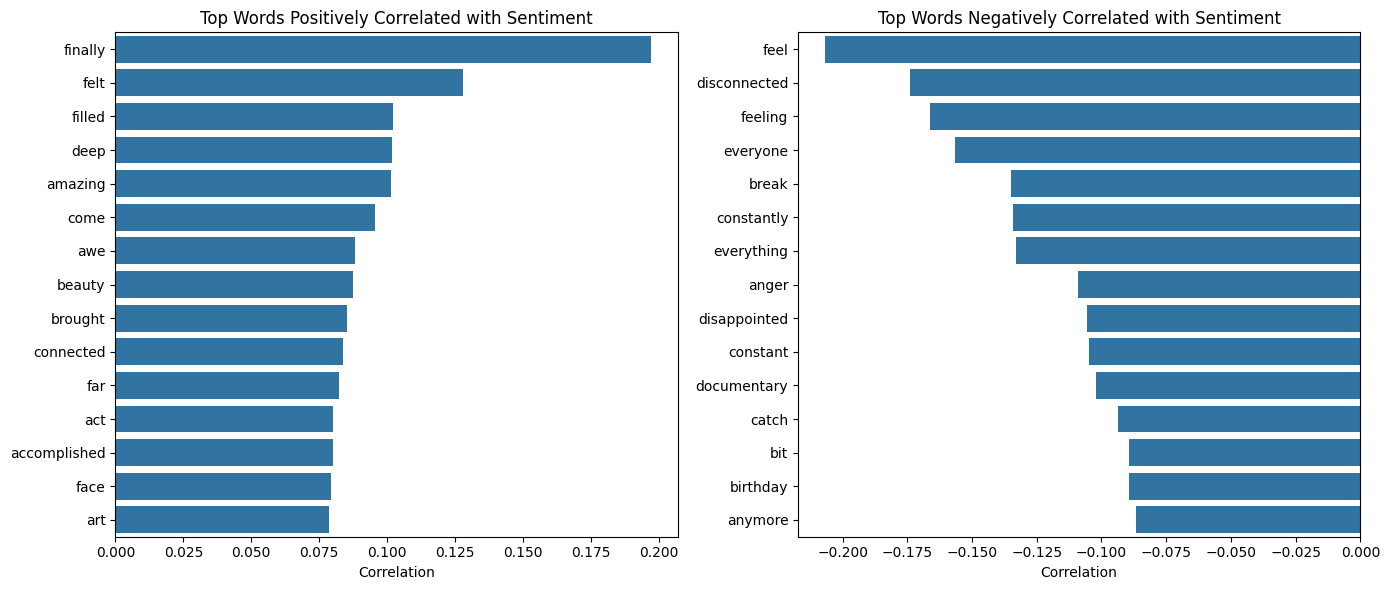


VADER Sentiment Analysis:


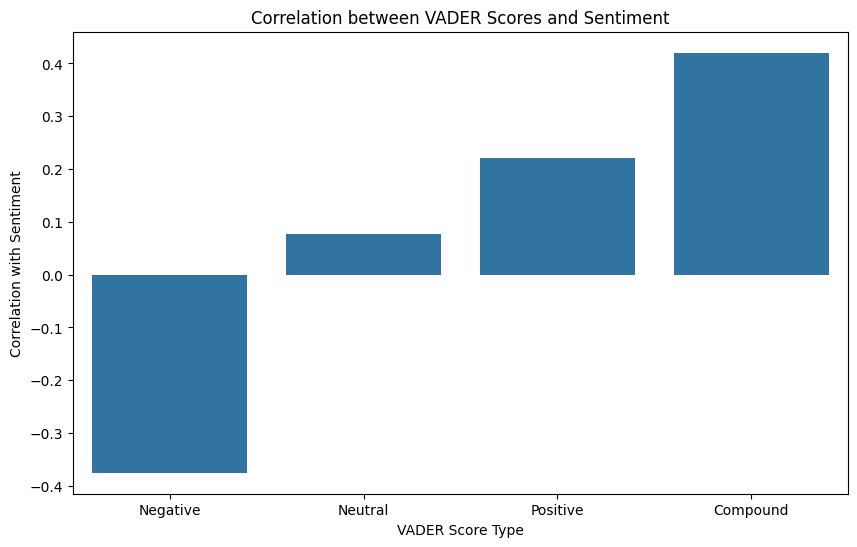

Negative: -0.3753
Neutral: 0.0760
Positive: 0.2213
Compound: 0.4202

Custom Lexicon Analysis:


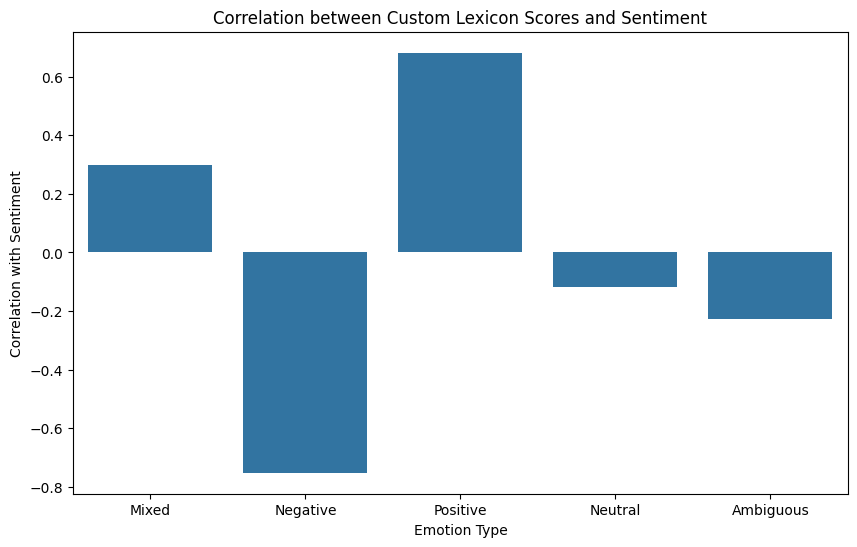

Mixed: 0.2970
Negative: -0.7517
Positive: 0.6816
Neutral: -0.1183
Ambiguous: -0.2271


In [41]:
def analyze_sentiment_correlations(features, df):

    """
    Analyze correlations between features and sentiment labels
    
    Parameters:
    features (dict): Dictionary containing feature representations
    df (pd.DataFrame): Original dataframe with sentiment labels
    """
    print("\n--- Sentiment Correlation Analysis ---")
    
    # Create a fixed, ordered mapping for sentiment labels (JUST FOR CORRELATION)
    sentiment_order = {
        'Negative': 0,  # Most negative
        'Ambiguous': 1, 
        'Neutral': 2,   # Middle point
        'Mixed': 3,
        'Positive': 4   # Most positive
    }
    
    # Apply this consistent mapping ONLY for the correlation calculation
    sentiment_numeric = df['sentiment'].map(sentiment_order)
    
    # Analyze TFIDF features with proper sentiment encoding
    if 'tfidf' in features and isinstance(features['tfidf'], tuple):
        tfidf_vectorizer = features['tfidf'][1]
        tfidf_features = features['tfidf'][0]
        
        # Calculate correlation with sentiment using proper encoding
        feature_names = tfidf_vectorizer.get_feature_names_out()
        word_sentiment_corr = []
        
        print("\nAnalyzing word correlations with sentiment...")
        for i in range(min(1000, tfidf_features.shape[1])):
            feature_column = tfidf_features[:, i].toarray().flatten()
            corr, _ = pearsonr(feature_column, sentiment_numeric)
            word_sentiment_corr.append((feature_names[i], corr))
            
        # Sort by absolute correlation
        top_positive_words = sorted(word_sentiment_corr, key=lambda x: x[1], reverse=True)[:15]
        top_negative_words = sorted(word_sentiment_corr, key=lambda x: x[1])[:15]
    
    # Analyze TFIDF features
    if 'tfidf' in features and isinstance(features['tfidf'], tuple):
        tfidf_vectorizer = features['tfidf'][1]
        tfidf_features = features['tfidf'][0]
        
        # Calculate correlation with sentiment
        feature_names = tfidf_vectorizer.get_feature_names_out()
        word_sentiment_corr = []
        
        print("\nAnalyzing word correlations with sentiment...")
        for i in range(min(1000, tfidf_features.shape[1])):  # Limit to first 1000 features to save time
            feature_column = tfidf_features[:, i].toarray().flatten()
            corr, _ = pearsonr(feature_column, sentiment_numeric)
            word_sentiment_corr.append((feature_names[i], corr))
        
        # Sort by absolute correlation
        top_positive_words = sorted(word_sentiment_corr, key=lambda x: x[1], reverse=True)[:15]
        top_negative_words = sorted(word_sentiment_corr, key=lambda x: x[1])[:15]
        
        print("\nTop Positive Sentiment Words:")
        for word, corr in top_positive_words:
            print(f"{word}: {corr:.4f}")
        
        print("\nTop Negative Sentiment Words:")
        for word, corr in top_negative_words:
            print(f"{word}: {corr:.4f}")
        
        # Visualize top correlated words
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        words = [x[0] for x in top_positive_words]
        corrs = [x[1] for x in top_positive_words]
        sns.barplot(x=corrs, y=words)
        plt.title('Top Words Positively Correlated with Sentiment')
        plt.xlabel('Correlation')
        
        plt.subplot(1, 2, 2)
        words = [x[0] for x in top_negative_words]
        corrs = [x[1] for x in top_negative_words]
        sns.barplot(x=corrs, y=words)
        plt.title('Top Words Negatively Correlated with Sentiment')
        plt.xlabel('Correlation')
        
        plt.tight_layout()
        plt.savefig('word_sentiment_correlations.png', dpi=300)
        plt.show()
    
    # Analyze VADER features
    if 'vader' in features and isinstance(features['vader'], np.ndarray):
        print("\nVADER Sentiment Analysis:")
        vader_features = features['vader']
        vader_columns = ['Negative', 'Neutral', 'Positive', 'Compound']
        
        # Calculate correlation between VADER scores and sentiment
        corrs = []
        for i in range(vader_features.shape[1]):
            corr, _ = pearsonr(vader_features[:, i], sentiment_numeric)
            corrs.append(corr)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=vader_columns, y=corrs)
        plt.title('Correlation between VADER Scores and Sentiment')
        plt.xlabel('VADER Score Type')
        plt.ylabel('Correlation with Sentiment')
        plt.savefig('vader_sentiment_correlations.png', dpi=300)
        plt.show()
        
        for i, col in enumerate(vader_columns):
            print(f"{col}: {corrs[i]:.4f}")
    
    # Analyze Custom Lexicon features
    if 'my_features' in features and isinstance(features['my_features'], np.ndarray):
        print("\nCustom Lexicon Analysis:")
        lexicon_features = features['my_features']
        emotion_labels = ['Mixed', 'Negative', 'Positive', 'Neutral', 'Ambiguous']
        
        # Calculate correlation between lexicon scores and sentiment
        corrs = []
        for i in range(lexicon_features.shape[1]):
            corr, _ = pearsonr(lexicon_features[:, i], sentiment_numeric)
            corrs.append(corr)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=emotion_labels, y=corrs)
        plt.title('Correlation between Custom Lexicon Scores and Sentiment')
        plt.xlabel('Emotion Type')
        plt.ylabel('Correlation with Sentiment')
        plt.savefig('custom_lexicon_correlations.png', dpi=300)
        plt.show()
        
        for i, emo in enumerate(emotion_labels):
            print(f"{emo}: {corrs[i]:.4f}")

analyze_sentiment_correlations(features, df)